## VAR at 2018 World Cup: Python Exploration
This notebook explores the effect of Video Assistant Referee (VAR) system in the 2018 World Cup in Russia. This was the first time VAR was used in the World Cup and it has certainly made the news on more than one occasion. The system uses multi-angle video feeds to assist referees in making the right calls during the game.

In [207]:
# Import all of the usual libraries for analysis...
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ...set appropriate chart type for Jupyter
%matplotlib inline
sns.set(font_scale=1.3)
plt.rcParams['figure.figsize'] = [14, 7]

## The Data
While scored penalties in all historic World Cup tournaments are readily availble from the [Guardian Data Blog](https://www.theguardian.com/news/datablog/2010/may/05/world-cup-historical-statistics#data), getting the number of awarded penalties (including missed and saved shots) has proven to be tricky. After a few hours of scouring the internet and almost resorting to watching recaps of games, I came accross an amazing resource that contains the data in text format, going back to 1930. [Linguasport](http://www.linguasport.com/) has short description of every match in the World Cup history, inclusing an easy to parse section called "Incidents" that includes penalty misses, saves, player names, bookings, and anything else that is out of the ordinary for each game. I've put together a dataset that captures the penalty information at an aggregate level. Since the dataset is very small and I carefully built it myself, I can dive directly into feature creation and exploration, without doing much integrity checking or cleaning.

In [216]:
penData = pd.read_csv('penalties_stats_aa.csv')
penData.head()

,Year,Host,MatchesPlayed,PenaltiesScored,PenaltiesAwarded,PenaltiesSaved,PenaltiesMissed
0,1930,Uruguay,18,1,4,3,0
1,1934,Italy,17,3,5,1,1
2,1938,France,18,3,5,1,1
3,1950,Brazil,22,3,3,0,0
4,1954,Switzerland,26,7,7,0,1


## Penalties per Match
First, we can see the that number of penalties has been increasing since the original 1930 tournament. However, this is simply due to the fact that much fewer games were played back then compared to modern format (18 games in 1930 vs. 64 games this year). 
I will create a variable that takes number of games into account, call it *PenaltiesPerMatch*. Creating a barplot of that variable indicates that the 2018 World Cup had a penalty almost every two games - a rate that has never been seen before in the tournament.

*Note that at the time of writing, only 59 games have been played in 2018 World Cup. I hope to revisit the notebook later.*

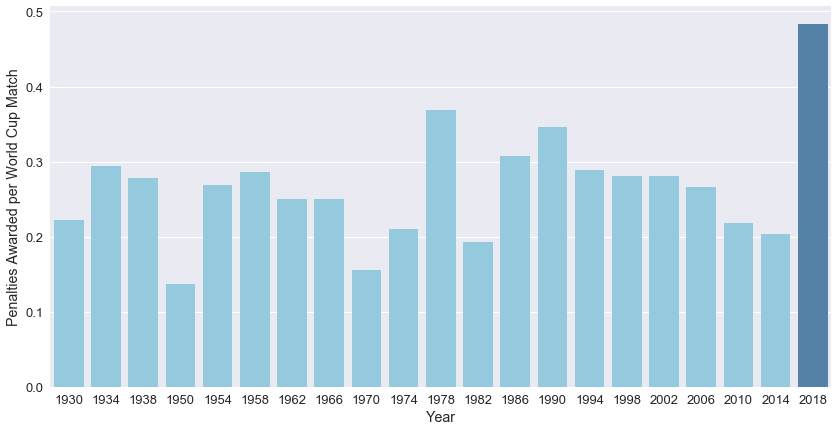

In [258]:
penData['PenaltiesPerMatch'] = penData['PenaltiesAwarded']/penData['MatchesPlayed']
sns.barplot(x='Year', y='PenaltiesPerMatch', data=data, ci=None, palette=['skyblue']*(data.shape[0]-1) + ['steelblue'])
plt.ylabel("Penalties Awarded per World Cup Match");

The outlier is even more apparent in a boxplot, where the 2018 *PenaltiesPerMatch* are close to 3 standard deviations away from the median.

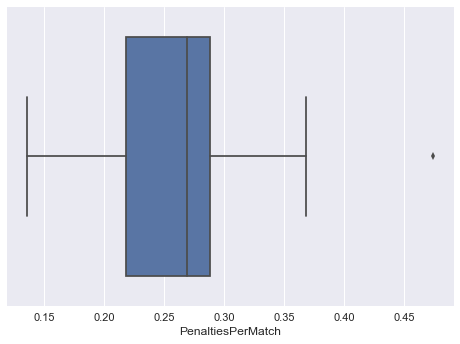

In [274]:
sns.boxplot(penData.PenaltiesPerMatch)

Had this been a normal distirbution (which it is not) we would have to say that the 2018 penalties awarded do not fit this distribution. No matter how we slice it, there seems to be a shift that happened this year with respect to penalties.

## Penalties due to VAR?
Once again turning to Linguasport source and other publications, I was able to find all of the penalty instances in 2018 World Cup where the penalty kick decision was either made due to or confirmed by VAR (Source: [The Sun](https://www.thesun.co.uk/world-cup-2018/6549345/penalties-at-world-cup-2018/)). There is only a handfull of such cases:
* Australia scored vs. Denmark - VAR-assisted decision
* Iran scored vs. Portugal - VAR-assisted decision
* Belgium scored vs. Tunisia - VAR-assisted decision
* France scored vs. Australia - confirmed by VAR
* Sweden scored vs. South Korea - confirmed by VAR
* Iceland missed vs. Nigeria - confirmed by VAR
* Peru missed vs. Denmark - confirmed by VAR
* Saudi Arabia saved by Egypt - confirmed by VAR

These numbers are already included in my penalties dataset. I will only add special columns called VARScore, VARMIss, and VARSave to visualize the effect.

In [219]:
penData['VARScore'] = [0]*(penData.shape[0]-1) + [5]
penData['VARMiss'] = [0]*(penData.shape[0]-1) + [3]
penData['VARSave'] = [0]*(penData.shape[0]-1) + [1]

It's time to make a bold assumption... For the sake of simplicity, let's say that all of the above penalties would not have been awarded if VAR technology was not there to support the decision. Of course there were a number of penalties that were overturned by VAR, which would have the opposite effect if the tehcnology was not there. Most notably, a penalty was overtuned by VAR in the match between Costa Rica and Argentina. There was also Brazil vs Belgium and Sweden vs Switzerland (Source: [ESPN](http://www.espn.com/soccer/fifa-world-cup/4/blog/post/3533707/var-at-the-world-cup-a-timeline-of-the-tournament)).  

In [220]:
woVARPenPerMatch = (penData.loc[20, 'PenaltiesAwarded'] - penData.iloc[20, 8:11].sum()) / penData.loc[20, 'MatchesPlayed']
print("2018 Penalty Rate without VAR penalties: %.3f" % woVARPenPerMatch)

2018 Penalty Rate without VAR penalties: 0.339


This is closer to a normal penalty rate and is in fact less than the penalty rate of Argentina 1978 and Italy 1990. However, with the 3 penalties that have been overturned by VAR, Russian 2018 would still have the highest rate of penalties per game, though not as dramatic.

In [226]:
penData[woVARPenPerMatch < penData.PenaltiesPerMatch].loc[[10, 13], ['Year', 'Host', 'PenaltiesPerMatch']]

,Year,Host,PenaltiesPerMatch
10,1978,Argentian,0.368421
13,1990,Italy,0.346154


In [276]:
VARScenarios = penData.append([penData], ignore_index=True)
VARScenarios['VARScenario'] = ['Excluding all VAR penalties']*(penData.shape[0]) + ['Include VAR-overturned penalties']*(penData.shape[0])
VARScenarios.loc[20,'PenaltiesPerMatch'] = woVARPenPerMatch
VARScenarios.loc[41,'PenaltiesPerMatch'] = (penData.loc[20, 'PenaltiesAwarded'] - penData.iloc[20, 8:11].sum() + 3) / penData.loc[20, 'MatchesPlayed']

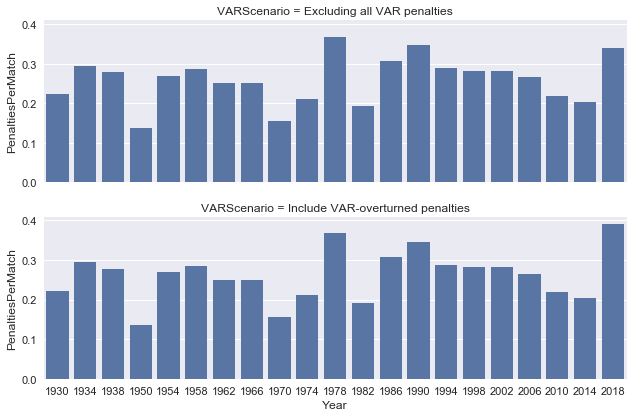

In [277]:
sns.set(font_scale=1.1)
g = sns.FacetGrid(VARScenarios, row="VARScenario", aspect=3)
g = g.map(sns.barplot, 'Year', 'PenaltiesPerMatch')

The top bargraph shows the penalty rates if all VAR penalties are excluded from the calculation. The bottom boxplot shows the scenario where all VAR penalties are excluded, but all VAR overtuned penalties are included. 

In conclusion I would say that this world cup has seen an unprecendented rate of penalties. There is evidence to suggest that the increase is due to the use of VAR. Excluding VAR penalties would not make 2018 World Cup out of the ordinary, historically speaking. However, other factors (including chance) may be at play here as VAR did overturn at least 3 penalty calls which would otherwise be awarded.

## Bonus: Converted Penalties Over the Years

With the available data, I can't help but ask: did teams get better at converting in-game penalties? For this I'll add two simple features, *ScoreRate* and *MissRate*, for each competition.

In [284]:
penData['ScoreRate'] = penData['PenaltiesScored'] / penData['PenaltiesAwarded']
penData['MissRate'] = (penData['PenaltiesAwarded'] - penData['PenaltiesScored']) / penData['PenaltiesAwarded']

Plotting these in an area chart shows that up to about 1954 penalty takers did improve their strikes. Following that competition, the penalty conversion rate has stabilized around the 80% mark, on average.

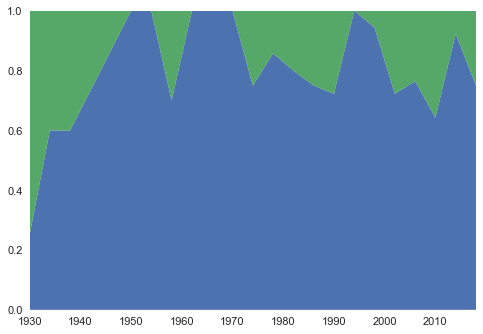

In [317]:
plt.stackplot(penData.Year, [penData.ScoreRate, penData.MissRate], labels=['Miss', 'Score'])
plt.xlim(min(penData.Year),max(penData.Year))
plt.ylim(0, 1);

I will conclude this notebook by computing the averate penalty conversion rate from all World Cup tournaments since 1930.

In [318]:
print("Average in-game penalty conversion rate: %.1f%%" % (100*penData.ScoreRate.sum()/21))

Average in-game penalty conversion rate: 79.9%
